In [4]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from collections import Counter  

 
from sklearn.tree import DecisionTreeClassifier
import sklearn.metrics as metrics

from sklearn.model_selection import GridSearchCV

import pickle

In [5]:
#Datos de Diabetes
datos_diabetes = pd.read_csv('/home/juan/machineLearning2025/datasets/diabetes_012_health_indicators_BRFSS2015.csv')

datos_diabetes

,Diabetes_012,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253675,0.0,1.0,1.0,1.0,45.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,3.0,0.0,5.0,0.0,1.0,5.0,6.0,7.0
253676,2.0,1.0,1.0,1.0,18.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,4.0,0.0,0.0,1.0,0.0,11.0,2.0,4.0
253677,0.0,0.0,0.0,1.0,28.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,5.0,2.0
253678,0.0,1.0,0.0,1.0,23.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,3.0,0.0,0.0,0.0,1.0,7.0,5.0,1.0


In [6]:
#Crear la columna diabetes_01 que unifique prediabetes con diabetes
datos_diabetes['diabetes_01'] = datos_diabetes['Diabetes_012']
datos_diabetes['diabetes_01'] = datos_diabetes['diabetes_01'].replace(2,1)

#Reparar nombres de columnas. Se usa el formato loweCamelCase para el nombre de las caracteristicas.

new_col_names = []

for name in datos_diabetes.columns:
    # Luego, pon todas las letras en minúsculas
    name_lowered_first_letter = name[0].lower() + name[1:]
    # Elimina los espacios al principio y al final
    name_stripped = name_lowered_first_letter.strip()
    # Por último, reemplaza los espacios entre palabras por guiones bajos
    name_no_spaces = name_stripped.replace(' ', '_')
    # Agrega el nuevo nombre a la lista de nuevos nombres de columna
    new_col_names.append(name_no_spaces)

datos_diabetes.columns = new_col_names

datos_diabetes = datos_diabetes.rename(columns={'bMI':'bmi'})

datos_diabetes.columns


#Definicion de datos enteros.
for col in datos_diabetes.columns:
    #if datos_diabetes[col].dtype == 'float64':
    datos_diabetes[col] = datos_diabetes[col].astype(int)

In [7]:
def evaluate_model(model, train_features, train_target, test_features, test_target):
   
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # Valor F1
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'Valor F1') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'Curva ROC')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')   
        
        eval_stats[type]['Exactitud'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Exactitud', 'F1', 'APS', 'ROC AUC'))
    
    #print(df_eval_stats)
    
    return  df_eval_stats, fig#eval_stats['train']['F1'], eval_stats['test']['F1']

In [8]:
#split
from sklearn.model_selection import train_test_split
X = datos_diabetes.drop(["diabetes_01", "diabetes_012"], axis=1)
y = datos_diabetes["diabetes_01"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)


In [ ]:
# Balanceo con RandomOverSample

os =  RandomOverSampler()
X_train_res_RandOvSamp, y_train_res_RandOvSamp = os.fit_resample(X_train, y_train)
 
print ("before resampling {}".format(Counter(y_train)))
print ("after resampling {}".format(Counter(y_train_res_RandOvSamp)))


before resampling Counter({0: 160225, 1: 30035})
after resampling Counter({0: 160225, 1: 160225})


In [9]:
os_us = SMOTE()
X_train_res_SMOTE, y_train_res_SMOTE= os_us.fit_resample(X_train, y_train)

print ("before resampling {}".format(Counter(y_train)))
print ("after resampling {}".format(Counter(y_train_res_SMOTE)))


before resampling Counter({0: 160225, 1: 30035})
after resampling Counter({0: 160225, 1: 160225})


In [ ]:
# Arboles de desicion desbalanceado

model_desicionTree_unbalanced = DecisionTreeClassifier()

'''
Parámetros utilizados: 
*criterion: funciones utilizadas para estimar la impureza de una región.
*max_depth: la profundidad máxima del árbol. (Profundidad de la rama mas larga).
*min_samples_split: Cantidad mínima de observaciones en un nodo para realizar una división
(crear una nueva regla). Un valor alto impide que el árbol se divida en nodos con grupos pequeños
de observaciones, lo que previene el sobreajuste al disminuir la complejidad del árbol.
*min_samples_leaf: Número mínimo de observaciones que tendrá una hoja. Ayuda a controlar el sobreajuste.
Cuando se evalua una división y la hoja resutante tiene menos de min_samples_leaf observaciones, la hoja
no es creada.


'''
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 1, 5 ,10, 20],
    'min_samples_split': [2, 5 ,10, 20],
    'min_samples_leaf': [1, 5, 10]
}

grid_search_desicionTree_unbalanced = GridSearchCV(estimator=model_desicionTree_unbalanced, param_grid=param_grid, cv=5, scoring='f1',n_jobs=-1)


# Entrenar el modelo con Grid Search
grid_search_desicionTree_unbalanced.fit(X_train, y_train)

# Imprimir los mejores hiperparámetros y el mejor puntaje
print("Mejores hiperparámetros:", grid_search_desicionTree_unbalanced.best_params_)
print("Mejor precisión:", grid_search_desicionTree_unbalanced.best_score_)

Mejores hiperparámetros: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 5, 'min_samples_split': 5}
Mejor precisión: 0.3322490179100973


In [ ]:
#GUardar
model_pkl_file = "dt_unbalanced.pkl"

with open(model_pkl_file, 'wb') as file:
    pickle.dump(grid_search_desicionTree_unbalanced.best_estimator_, file)

(           train  test
 Exactitud   0.90  0.82
 F1          0.63  0.34
 APS         0.75  0.31
 ROC AUC     0.95  0.70,
 <Figure size 2000x600 with 3 Axes>)

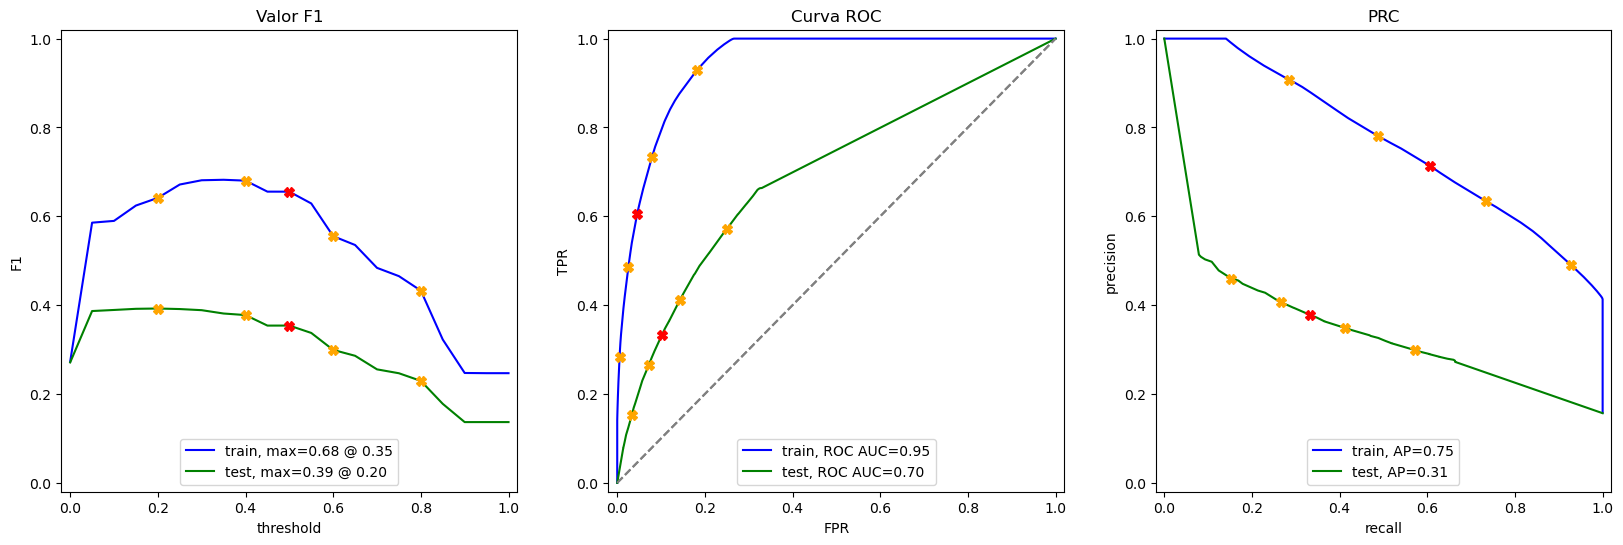

In [ ]:
#with open(model_pkl_file, 'rb') as file:  
#    model = pickle.load(file)
#df_metrics, fig=evaluate_model(grid_search_desicionTree_unbalanced, X_train, y_train, X_test, y_test)

#df_metrics.to_csv('metrics_dt_unbalanced.csv')

#with open('fig_dt_unbalanced.pkl', 'wb') as f:
#    pickle.dump(fig, f)

with open("dt_unbalanced.pkl", 'rb') as file:  
    model = pickle.load(file)
evaluate_model(model, X_train, y_train, X_test, y_test)

In [ ]:
model_desicionTree_RandOvSamp = DecisionTreeClassifier()



param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 1, 5 ,10, 20],
    'min_samples_split': [2, 5 ,10, 20],
    'min_samples_leaf': [1, 5, 10]
}

grid_search_desicionTree_RandOvSamp = GridSearchCV(estimator=model_desicionTree_RandOvSamp, param_grid=param_grid, cv=5, scoring='f1',n_jobs=-1)


# Entrenar el modelo con Grid Search
grid_search_desicionTree_RandOvSamp.fit(X_train_res_RandOvSamp, y_train_res_RandOvSamp)

# Imprimir los mejores hiperparámetros y el mejor puntaje
print("Mejores hiperparámetros:", grid_search_desicionTree_RandOvSamp.best_params_)
print("Mejor precisión:", grid_search_desicionTree_RandOvSamp.best_score_)

Mejores hiperparámetros: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Mejor precisión: 0.9243204356476558


(           train  test
 Exactitud   0.99  0.78
 F1          0.99  0.31
 APS         1.00  0.21
 ROC AUC     1.00  0.59,
 <Figure size 2000x600 with 3 Axes>)

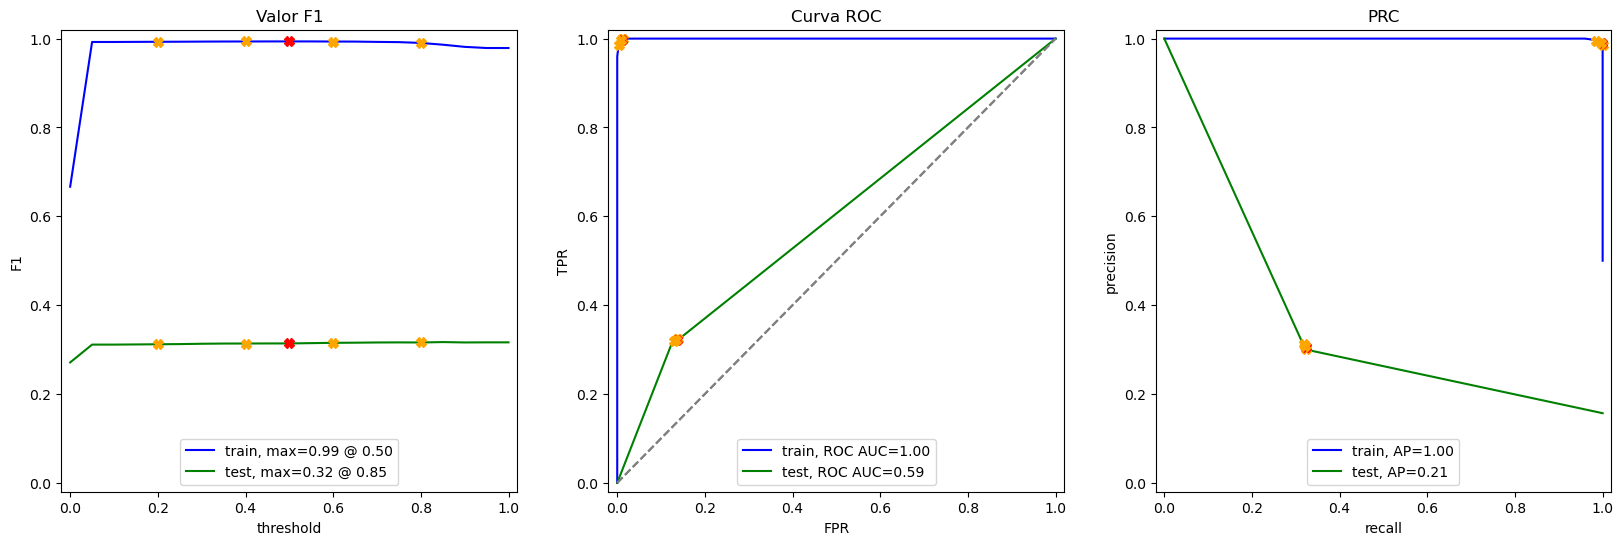

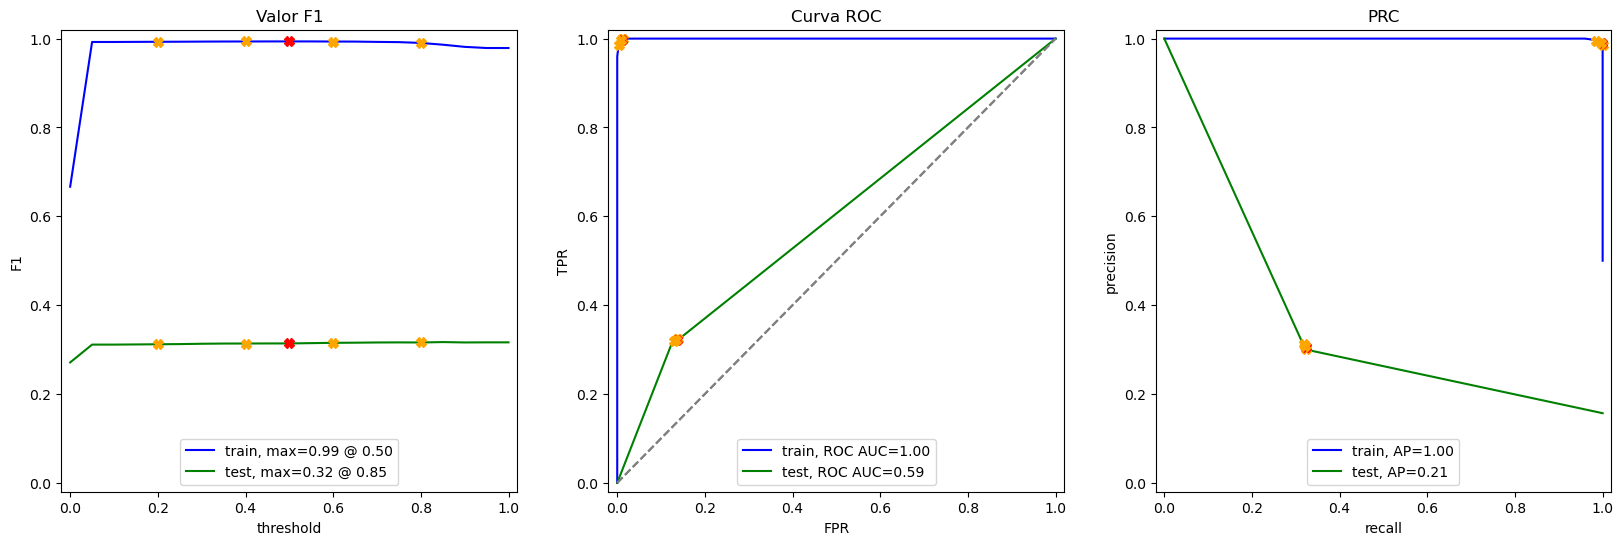

In [ ]:
#GUardar modelo
model_pkl_file = "dt_RandOvSamp.pkl"

with open(model_pkl_file, 'wb') as file:
    pickle.dump(grid_search_desicionTree_RandOvSamp.best_estimator_, file)


df_metrics2, fig2=evaluate_model(grid_search_desicionTree_RandOvSamp.best_estimator_, X_train_res_RandOvSamp, y_train_res_RandOvSamp, X_test, y_test)

df_metrics2.to_csv('metrics_dt_RandOvSamp.csv')

with open('fig_dt_RandOvSamp.pkl', 'wb') as f:
    pickle.dump(fig2, f)

evaluate_model(grid_search_desicionTree_RandOvSamp.best_estimator_, X_train_res_RandOvSamp, y_train_res_RandOvSamp, X_test, y_test)

In [ ]:
#DT con RAndOvSamp y sus mejores 4 caracteristicas (bmi, age, income, genHlth)
model_desicionTree_RandOvSamp_best4 = DecisionTreeClassifier()

X_train_res_RandOvSamp_best4= X_train_res_RandOvSamp[['bmi', 'age', 'income', 'genHlth']]

X_test_RandOvSamp_best4 =X_test[['bmi', 'age', 'income', 'genHlth']]

param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 1, 5 ,10, 20],
    'min_samples_split': [2, 5 ,10, 20],
    'min_samples_leaf': [1, 5, 10]
}

grid_search_desicionTree_RandOvSamp_best4 = GridSearchCV(estimator=model_desicionTree_RandOvSamp_best4, param_grid=param_grid, cv=5, scoring='f1',n_jobs=-1)


# Entrenar el modelo con Grid Search
grid_search_desicionTree_RandOvSamp_best4.fit(X_train_res_RandOvSamp_best4, y_train_res_RandOvSamp)

# Imprimir los mejores hiperparámetros y el mejor puntaje
print("Mejores hiperparámetros:", grid_search_desicionTree_RandOvSamp_best4.best_params_)
print("Mejor precisión:", grid_search_desicionTree_RandOvSamp_best4.best_score_)

Mejores hiperparámetros: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Mejor precisión: 0.7592592212705818


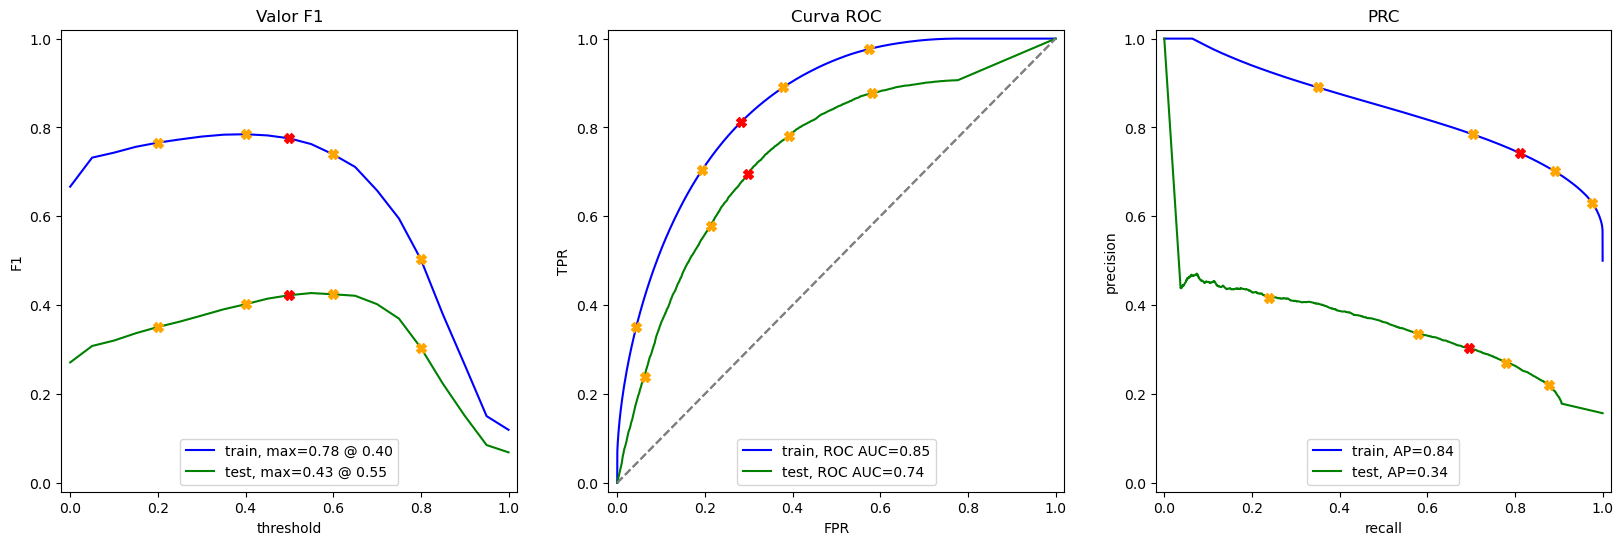

In [ ]:
with open("dt_RandOvSamp_best4.pkl", 'wb') as file:
    pickle.dump(grid_search_desicionTree_RandOvSamp_best4.best_estimator_, file)

df_metrics2, fig2=evaluate_model(grid_search_desicionTree_RandOvSamp_best4.best_estimator_, X_train_res_RandOvSamp_best4, y_train_res_RandOvSamp, X_test_RandOvSamp_best4, y_test)

df_metrics2.to_csv('metrics_dt_RandOvSamp_best4.csv')

with open('fig_dt_RandOvSamp_best4.pkl', 'wb') as f:
    pickle.dump(fig2, f)


In [12]:
#Datos balanceados con SMOTE

model_desicionTree_SMOTE = DecisionTreeClassifier()

param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 1, 5 ,10, 20],
    'min_samples_split': [2, 5 ,10],
    'min_samples_leaf': [1, 5, 10]
}

grid_search_desicionTree_SMOTE = GridSearchCV(estimator=model_desicionTree_SMOTE, param_grid=param_grid, cv=5, scoring='f1',n_jobs=-1)


# Entrenar el modelo con Grid Search
grid_search_desicionTree_SMOTE.fit(X_train_res_SMOTE, y_train_res_SMOTE)

# Imprimir los mejores hiperparámetros y el mejor puntaje
print("Mejores hiperparámetros:", grid_search_desicionTree_SMOTE.best_params_)
print("Mejor precisión:", grid_search_desicionTree_SMOTE.best_score_)

Mejores hiperparámetros: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Mejor precisión: 0.8141428347213644


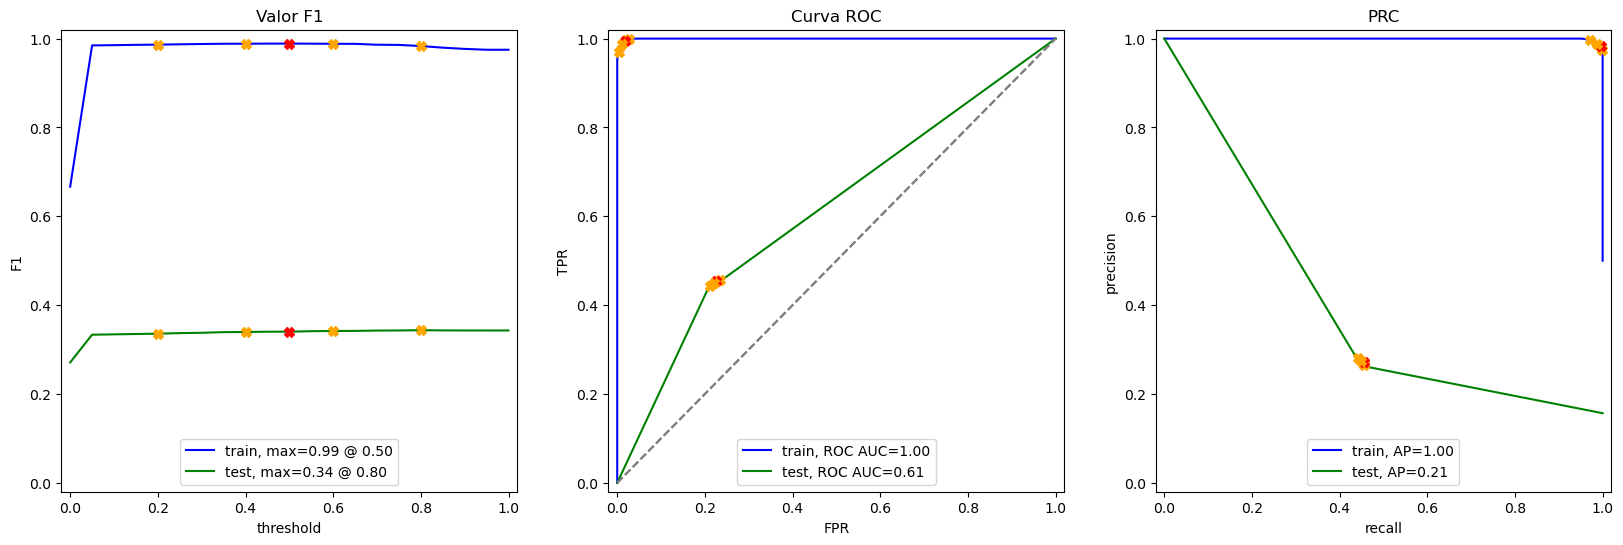

In [13]:
with open("dt_SMOTE.pkl", 'wb') as file:
    pickle.dump(grid_search_desicionTree_SMOTE.best_estimator_, file)

df_metrics2, fig2=evaluate_model(grid_search_desicionTree_SMOTE.best_estimator_, X_train_res_SMOTE, y_train_res_SMOTE, X_test, y_test)

df_metrics2.to_csv('metrics_dt_SMOTE.csv')

with open('fig_dt_SMOTE.pkl', 'wb') as f:
    pickle.dump(fig2, f)